# Code for generating Figure 1
## "Conservation laws relevant to simple decision-making and decision memory models"

This self-contained Python notebook contains code for generating the first figure from the [NeurReps](https://www.neurreps.org) 2024 paper **"Dynamical symmetries in the fluctuation-driven regime: an application of Noether's theorem to noisy dynamical systems"**.

In [153]:
# imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch

<center>
<img src="fig_decision.png" width="800"/></center>

**Conservation laws relevant to simple decision-making and decision memory models.** **a.** For a drift-diffusion model with fixed decision bounds at $\pm 1$, the most likely path from any evidence state to the opposite boundary is (approximately) a straight line (blue, 'LAP'). Raw paths ($n = 981$) with same start state, end state, and transition time also shown. **b.** Transitions between two states of a single-attractor model (heatmap: steady state distribution) are direct when energy and angular momentum are high, and involve a diversion to the attractor state when they are low.  **c.** Transitions between two attractor basins in a model with three attractors (heatmap: steady state distribution) are more direct when energy is high, and involve visiting an intermediate attractor when energy is low.

## Panel a. Approximate momentum conservation in drift-diffusion models

In [21]:
# USEFUL FUNCTIONS

# simple 1D SDE simulator
def simulate_SDE(x0, num_tsteps, num_runs, dt, f, g, params):
    x = x0*np.ones((num_tsteps + 1, num_runs))
    t = np.linspace(0, num_tsteps*dt, num_tsteps+1)
    y = np.zeros((num_tsteps + 1, num_runs))
                 
    for i in range(num_tsteps):
        x[i+1], y[i+1] = euler_maruyama(x[i], y[i], t[i], dt, f, g, params)   
    return t, x, y

# 1D euler-maruyama steps
def euler_maruyama(x, y, t, dt, f, g, params):
    x_new = x + (f(x, t, params)*dt + g(x, t, params)*np.random.normal(size=x.shape)*np.sqrt(dt))*(1.-y)
    x_new = np.clip(x_new, -1, 1)
    y_new = (x_new**2 >= 1)
    return x_new, y_new
    
# trivial drift function: constant bias
def f_const(x, t, params):
    v = params['v']
    return v

# trivial noise function: constant gaussian noise
def g_const(x, t, params):
    sig = params['sig']
    return sig

Simulate drift-diffusion trajectories.

In [86]:
np.random.seed(0)
x0 = 0.5              # initial condition: biased towards upper boundary

num_tsteps = 40       # number of time steps
num_runs = 100000     # number of trajectories to simulate
dt = 0.025            # size of time step

v, sig = 0.1, 1              # bias, noise strength
params = {'v':v, 'sig':sig}

# simulate evidence accumulation trajectories via euler-maruyama steps
t, x, y = simulate_SDE(x0, num_tsteps, num_runs, dt, f_const, g_const, params)

In [88]:
x_f = -1   # final point
T = 1      # transition time

p = ((x_f - x0)/T - v)/(sig**2)      # value of momentum, assuming it is conserved and ignoring boundary effects
print(p)

-1.6


Pick out trajectories with a specific endpoint (bottom boundary) and transition time (between 0.95 and 1) and compute the mean, median, and standard deviation of these trajectories.

In [93]:
# Get statistics of evidence accumulation trajectories

stops = np.argmax( y >= 1, axis=0)             # where hit boundary
lates = np.argwhere( t[stops] >= 0.95 )[:,0]   # filter for transition time between 0.95 and 1

n_ = np.arange(num_runs)
bottoms = np.argwhere( x[stops,n_] <= -1)[:,0]      # filter for hitting bottom boundary

both = list(set(lates).intersection(bottoms))     # valid trajectories: hit bottom boundary at time ~ 0.95 - 1
print('number of trajectories with correct endpoint and transition time: ', len(both))                                  # number of trajectories satisfying criteria

mu = np.mean(x[:,both],axis=-1)        # average valid trajectory
med = np.median(x[:,both],axis=-1)     # median valid trajectory
std = np.std(x[:,both],axis=-1)        # standard deviation in valid trajectory

number of trajectories with correct endpoint and transition time:  981


Generate figure (panel a of Figure 1).

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/zc/0zlq4_p94x78v648gqxpkhgw0000gn/T/ipykernel_68002/2470089069.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.fill_between(t, mu-std, mu+std, color='lightsalmon', alpha=0.6, label='$\mu \pm \sigma$')


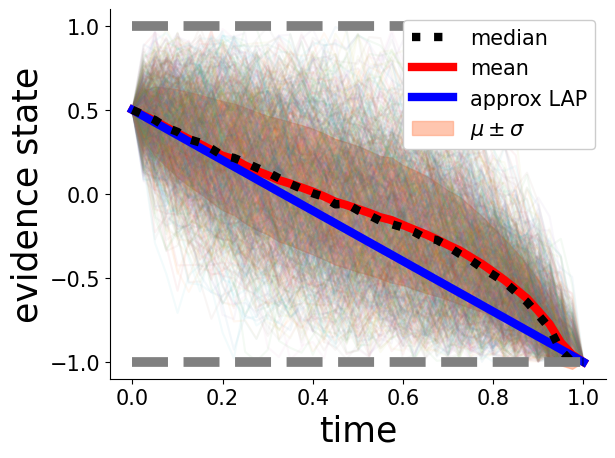

In [97]:
label_me = True   # if want x and y axis labels shown


fig, ax = plt.subplots()

ax.plot(t, med, color='black', zorder=4, linewidth=lw, linestyle='dotted', label='median')
ax.plot(t, mu, color='red', zorder=3, linewidth=lw, label='mean')

ax.plot(t, (-x0-1)*t + x0, color='blue', zorder=3, linewidth=lw, label='approx LAP')

ax.plot(t, np.ones_like(t), color='gray', linewidth=7, linestyle='--', zorder=4)
ax.plot(t, -np.ones_like(t), color='gray', linewidth=7, linestyle='--', zorder=4)

ax.plot(t, x[:,both], alpha=0.05)

ax.fill_between(t, mu-std, mu+std, color='lightsalmon', alpha=0.6, label='$\mu \pm \sigma$')
ax.spines[['right', 'top']].set_visible(False)
ax.legend(fontsize=15, framealpha=1)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylim(-1.1, 1.1)

if label_me:
    ax.set_xlabel('time', fontsize=25)
    ax.set_ylabel('evidence state', fontsize=25)

plt.savefig('results/drift-diff.png', bbox_inches='tight', transparent=True)
plt.savefig('results/drift-diff.pdf', bbox_inches='tight', transparent=True)
plt.show()

## Panel b. Energy and angular momentum in a monostable decision memory model

In [99]:
# get analytic result for least action path (LAP) of monostable model, computed by hand
def get_paths(x_0, x_T, y_0, y_T, T):
    num_t = 100; t_min = 0; t = np.linspace(t_min, T, num_t)
   
    x_t = (x_T - x_0*np.exp(-T))*(np.sinh(t)/np.sinh(T)) + x_0*np.exp(-t)
    x_dot = (x_T - x_0*np.exp(-T))*(np.cosh(t)/np.sinh(T)) - x_0*np.exp(-t)

    y_t = (y_T - y_0*np.exp(-T))*(np.sinh(t)/np.sinh(T)) + y_0*np.exp(-t)
    y_dot = (y_T - y_0*np.exp(-T))*(np.cosh(t)/np.sinh(T)) - y_0*np.exp(-t)
    return t, x_t, y_t, x_dot, y_dot

Get least action paths for monostable model for two different start and endpoints. (Each corresponds to different values of energy E and angular momentum L, which are conserved). 

In [101]:
# Get x and y grids
x_min, x_max, num_x = -2.5, 2.5, 100; y_min, y_max, num_y = -2.5, 2.5, 100
x = np.linspace(x_min, x_max, num_x); y = np.linspace(y_min, y_max, num_y)
X, Y = np.meshgrid(x, y, indexing='ij')

pdf = norm.pdf(X)*norm.pdf(Y)    # monostable model steady state distribution, assuming isotropic, mean zero, and variance one


# Get least action paths. One has high energy (E) and angular momentum (L), the other has both low.
t_lo, x_lo, y_lo, x_dot_lo, y_dot_lo = get_paths( -2, 2, 2, 2, 10 )
t_hi, x_hi, y_hi, x_dot_hi, y_dot_hi = get_paths( -2, 2, 2, 2, 1 )

Energy and angular momentum for the two paths (one where both are high, one where both are low).

In [104]:
L_hi = x_hi*y_dot_hi - y_hi*x_dot_hi
E_hi = x_dot_hi**2 + y_dot_hi**2 - x_hi**2 - y_hi**2 
print('High path, energy: ', E_hi[0])
print('High path, angular momentum: ', L_hi[0])


L_lo = x_lo*y_dot_lo - y_lo*x_dot_lo
E_lo = x_dot_lo**2 + y_dot_lo**2 - x_lo**2 - y_lo**2 
print('Low path, energy: ', E_lo[0])
print('Low path, angular momentum: ', L_lo[0])

# actually get a whole array of values for both, but the values are identical since E and L are conserved

High path, energy:  11.58498657546097
High path, angular momentum:  -6.8073450259145725
Low path, energy:  1.3191383096966547e-07
Low path, angular momentum:  -0.0007263988776968766


Generate figure (panel b of Figure 1).

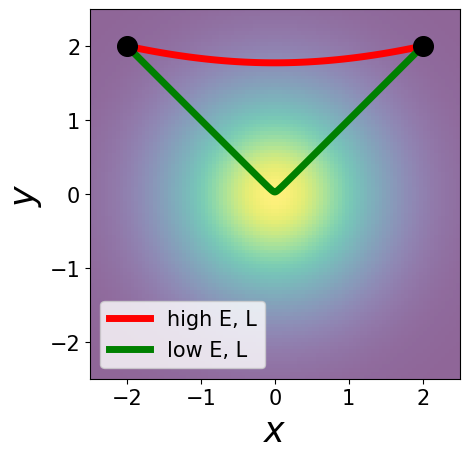

In [106]:
label_me = True   # if want x and y axis labels (and legend) shown


fig, ax = plt.subplots()

ax.plot(x_hi, y_hi, color='red',linewidth=5, label='high E, L')
ax.plot(x_lo, y_lo, color='green',linewidth=5, label='low E, L')

ax.imshow( pdf.T , origin='lower', alpha=0.6, extent=[x_min, x_max, y_min, y_max])
ax.scatter( -2, 2, color='black', s=200,zorder=3)
ax.scatter(2, 2, color='black', s=200,zorder=3)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_aspect('equal')


if label_me:
    ax.set_xlabel('$x$', fontsize=25)
    ax.set_ylabel('$y$', fontsize=25)
    ax.legend(fontsize=15)

plt.savefig('results/mono-path.png',bbox_inches='tight')
plt.savefig('results/mono-path.pdf', bbox_inches='tight')

plt.show()

## Panel c. Energy in a multistable decision memory model

In [116]:
# USEFUL FUNCTIONS: SDE SIMULATION

# simple 2D SDE simulator
def simulate_SDE(x0, y0, num_tsteps, num_runs, dt, f_x, f_y, g, params):
    x = x0*np.ones((num_tsteps + 1, num_runs))
    y = y0*np.ones((num_tsteps + 1, num_runs))
    
    t = np.linspace(0, num_tsteps*dt, num_tsteps+1)
    
    for i in range(num_tsteps):
        x[i+1], y[i+1] = euler_maruyama(x[i], y[i], t[i], dt, f_x, f_y, g, params)   
    return t, x, y

# 2D euler-maruyama step
def euler_maruyama(x, y, t, dt, f_x, f_y, g, params):
    x_new = x + f_x(x, y, t, params)*dt + g(x, y, t, params)*np.random.normal(size=x.shape)*np.sqrt(dt)
    y_new = y + f_y(x, y, t, params)*dt + g(x, y, t, params)*np.random.normal(size=y.shape)*np.sqrt(dt)
    return x_new, y_new
    

# bistable model drift function, x component
def f_x_bi(x, y, t, params):
    tau, mu_0, A, I, c, sig, n = params['tau'], params['mu_0'], params['A'], params['I'], params['c'], params['sig'], params['n']

    sigmoid_x = 1/(1 + np.exp(-(x-c)/n)); sigmoid_y = 1/(1 + np.exp(-(y-c)/n))
    f_x = ( mu_0 + A*sigmoid_x - I*sigmoid_y - x )/tau
    return f_x

# bistable model drift function, y component
def f_y_bi(x, y, t, params):
    tau, mu_0, A, I, c, sig, n = params['tau'], params['mu_0'], params['A'], params['I'], params['c'], params['sig'], params['n']

    sigmoid_x = 1/(1 + np.exp(-(x-c)/n)); sigmoid_y = 1/(1 + np.exp(-(y-c)/n))
    f_y = ( mu_0 + A*sigmoid_y - I*sigmoid_x - y )/tau
    return f_y

# isotropic noise function
def g_const(x, y, t, params):
    tau, sig = params['tau'], params['sig']
    g = np.sqrt(2/tau)*sig
    return g

In [110]:
# USEFUL FUNCTIONS: LEAST ACTION PATH COMPUTATION
# see here for inspiration for this code/idea: https://github.com/greydanus/ncf

# compute least action path via direct optimization
def get_LAP(z_0, z_f, num_time_pts, t_span, L, params, steps=1000, step_size=1e-1, num_prints=8, num_stashes=80):
    t_min, t_max = t_span
    t = torch.linspace(t_min, t_max, num_time_pts); t_ = np.linspace(t_min, t_max, num_time_pts)

    x = z_0[None,:]*(1 - (t[:,None] - t_min)/(t_max - t_min) ) + ( (t[:,None] - t_min)/(t_max - t_min) )*z_f[None,:]
    x.requires_grad = True
     
    print_on = np.linspace(0,int(np.sqrt(steps)),num_prints).astype(np.int32)**2 # print more often early in loop

    for i in range(steps):
        grad_x = torch.autograd.grad(action(x, t, L, params), x)[0]
        grad_x[[0,-1]] *= 0  # fix first and last coordinates by zeroing their grads
        x.data -= grad_x * step_size

        if i in print_on: print('step={:04d}, S={:.4e}'.format(i, action(x, t, L, params).item()))
    return t_, x

# get action given Lagrangian by integrating
def action(x, t, L, params):
    dt = t[1]-t[0]
    #print(dt)
    xdot = (x[1:] - x[:-1]) / dt     # finite difference approx of time derivative
    L_ = L(x[:-1], xdot, t[:-1], params)  
    return L_.mean()


# Lagrangian for a bistable decision memory model
def L_bistable(z, zdot, t, params):
    tau, mu_0, A, I, c, sig, n = params['tau'], params['mu_0'], params['A'], params['I'], params['c'], params['sig'], params['n']

    x_, y_ = z[:,0], z[:,1]
    sigmoid_x = torch.nn.functional.sigmoid((x_-c)/n); sigmoid_y = torch.nn.functional.sigmoid((y_-c)/n)
    
    f_x = ( mu_0 + A*sigmoid_x - I*sigmoid_y - x_ )/tau
    f_y = ( mu_0 + A*sigmoid_y - I*sigmoid_x - y_ )/tau
    
    L = (torch.square(zdot[:,0] - f_x) + torch.square(zdot[:,1] - f_y))/2
    return L
    

Simulate multistable decision memory model.

In [118]:
np.random.seed(0)
x0, y0 = 0, 0

num_tsteps = 2000
num_runs = 100000
dt = 0.025

off = 1
tau = 1; mu_0 = 0.25+off; c = 0.5+off; A = 2; I = 0.9; sig = 0.4; n=0.01

params = {'tau':tau, 'sig':sig, 'mu_0':mu_0, 'c':c, 'A':A, 'I':I, 'n':n}


t, x, y = simulate_SDE(x0, y0, num_tsteps, num_runs, dt, f_x_bi, f_y_bi, g_const, params)

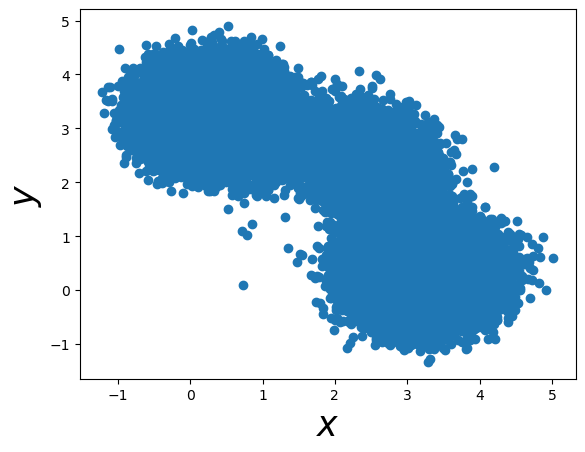

In [122]:
# simple scatter plot visualization of steady state distribution
plt.scatter(x[-1,:], y[-1,:])
plt.xlabel('$x$', fontsize=25); plt.ylabel('$y$', fontsize=25)
plt.show()

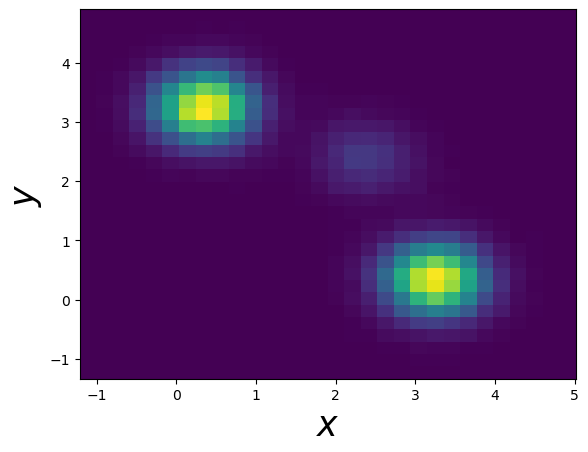

In [124]:
# heatmap visualization of steady state distribution
plt.hist2d(x[-1,:], y[-1,:],bins=30)
plt.xlabel('$x$', fontsize=25); plt.ylabel('$y$', fontsize=25)
plt.show()

Compute least action path via direct numerical optimization in two cases: for short transition time (high energy) and long transition time (low energy).

In [127]:
num_steps = 50
T = 40   
t_span = [0, T]

# labels are a little confusing: high/low here refers to transition time, which has an inverse relationship with energy
z_0 = torch.tensor([3,0.1]); z_f = torch.tensor([0.1, 3])
t_high, x_high = get_LAP(z_0, z_f, num_steps, t_span, L_bistable, params, steps=60000, step_size=1e-2)

path_high = x_high.detach().cpu().numpy()

step=0000, S=7.0241e-01
step=1156, S=4.0153e-01
step=4761, S=1.1466e-01
step=10816, S=4.0790e-02
step=19321, S=3.4217e-02
step=30276, S=3.3952e-02
step=43681, S=3.3917e-02
step=59536, S=3.3906e-02


In [129]:
num_steps = 50
T = 1   
t_span = [0, T]

z_0 = torch.tensor([3,0.1]); z_f = torch.tensor([0.1, 3])
t_low, x_low = get_LAP(z_0, z_f, num_steps, t_span, L_bistable, params, steps=60000, step_size=1e-3)

path_low = x_low.detach().cpu().numpy()

step=0000, S=9.1025e+00
step=1156, S=9.0208e+00
step=4761, S=9.0175e+00
step=10816, S=9.0175e+00
step=19321, S=9.0175e+00
step=30276, S=9.0175e+00
step=43681, S=9.0175e+00
step=59536, S=9.0175e+00


Generate figure (panel c of Figure 1). Plot most likely transition paths (for high energy, and low energy) overlaid over steady state distribution heatmap.

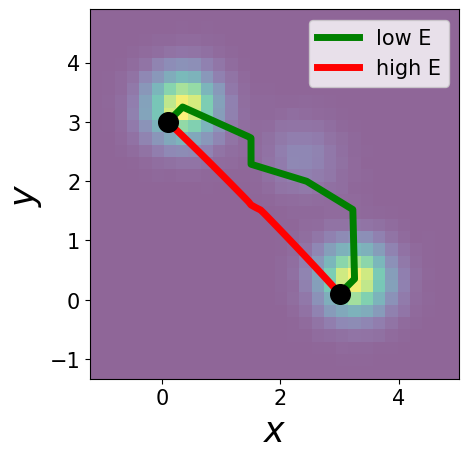

In [138]:
label_me = True   # if want x and y axis labels (and legend) shown

fig, ax = plt.subplots()

ax.set_aspect('equal')
# labels are a little confusing: high/low here refers to transition time, which has an inverse relationship with energy
ax.plot(path_high[:,0], path_high[:,1], color='green', linewidth=5, label='low E')
ax.plot(path_low[:,0], path_low[:,1], color='red', linewidth=5, label='high E')


ax.scatter( 3, 0.1, color='black', s=200,zorder=3)
ax.scatter(0.1, 3, color='black', s=200,zorder=3)
ax.hist2d(x[-1,:], y[-1,:],bins=30, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

if label_me:
    ax.set_xlabel('$x$', fontsize=25)
    ax.set_ylabel('$y$', fontsize=25)
    ax.legend(fontsize=15)

plt.savefig('results/bistable-2D-path.png',bbox_inches='tight')
plt.savefig('results/bistable-2D-path.pdf', bbox_inches='tight')
plt.show()